In [1]:
import matplotlib.pyplot as plt
import numpy as np
from joblib import dump, load
from itertools import cycle
import xarray as xr
from scipy.ndimage import generic_filter
import statsmodels.api as sm

kelp_files = [
    # output of the file: regressors_predict.py
    'Data/kelp_metrics_sim_27_37_GFDL-ESM4_ssp585_BGL_regressors.nc',
    'Data/kelp_metrics_sim_27_37_GFDL-ESM4_ssp126_BGL_regressors.nc',
]

kelp_watch = 'Data/kelp_metrics_27_37.pkl'

Data/overplot_GFDL-ESM4_BGL.png


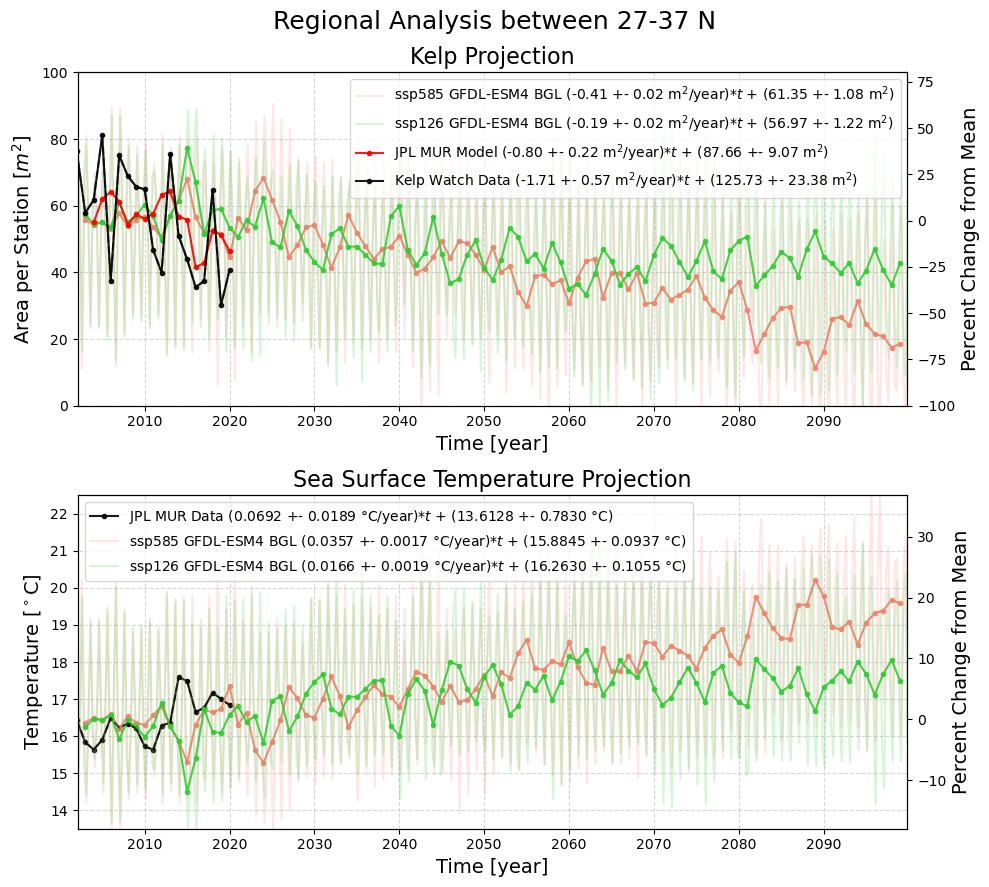

In [2]:
# create figure and overplot data
fig, ax = plt.subplots(2,1, figsize=(10,9))

colors = cycle(['salmon', 'limegreen', 'purple'])

# open kelp watch data
with open(kelp_watch, 'rb') as f:
    data = load(f)

# extract climate model, scenario, and scaling from file_path_sim
parts = kelp_files[0].split('_')
climate_scenario = parts[-2] # ssp585
climate_model = parts[-3] # GFDL-ESM4
scaling = parts[-1].split('.')[0]
north = parts[3]
south = parts[4]

fig.suptitle(f"Regional Analysis between {north}-{south} N", fontsize=18)

# compute yearly averages
years = data['time'].astype('datetime64[Y]').astype(int) + 1970
uyears = np.unique(data['time'].astype('datetime64[Y]'))
mean_year_kelp = []
std_year_kelp = []
mean_year_temp = []
std_year_temp = []
for y in np.unique(years):
    mask = years == y
    mean_year_kelp.append(np.percentile(data['kelp'][mask],70))
    #mean_year_kelp.append(np.mean(data['kelp'][mask]))
    std_year_kelp.append(data['kelp'][mask].std())
    #mean_year_temp.append((np.median(data['temp'][mask])+np.mean(data['temp'][mask]))/2)
    mean_year_temp.append(np.mean(data['temp'][mask]))
    std_year_temp.append(data['temp'][mask].std())

mean_year_temp = np.array(mean_year_temp)
std_year_temp = np.array(std_year_temp)

#ax[0].fill_between(uyears, np.array(mean_year_kelp)+np.array(std_year_kelp), np.array(mean_year_kelp)-np.array(std_year_kelp), color='k', alpha=0.2)
ax[0].set_ylabel(r'Area per Station [$m^2$]', fontsize=14)
ax[0].set_title('Kelp Projection', fontsize=16)

# fit a line to JPL MUR model
X = sm.add_constant(uyears.astype(int))
model = sm.OLS(mean_year_temp-273.15, X)
results = model.fit()
new_label = rf"JPL MUR Data ({results.params[1]:.4f} +- {results.bse[1]:.4f} °C/year)*$t$ +" + f" ({results.params[0]:.4f} +- {results.bse[0]:.4f} °C)"

# plot yearly temperature time series
ax[1].plot(uyears, mean_year_temp-273.15, '.-', color='k', alpha=0.9, label=new_label)
#ax[1].fill_between(uyears, np.array(mean_year_temp)+np.array(std_year_temp)-273.15, np.array(mean_year_temp)-np.array(std_year_temp)-273.15, color='k', alpha=0.2)
ax[1].set_ylabel(r'Temperature [$^\circ$C]', fontsize=14)
ax[1].set_title('Sea Surface Temperature Projection', fontsize=16)

# add second y-axis for temperature
ax2 = ax[1].twinx()
ax2.set_ylabel('Percent Change from Mean', fontsize=14)
ax2.plot(uyears, 100*(mean_year_temp-273.15-np.mean(mean_year_temp-273.15))/np.mean(mean_year_temp-273.15), 'k--', alpha=0.5)
ax2.set_ylim([(13.5-np.mean(mean_year_temp-273.15))/np.mean(mean_year_temp-273.15)*100, (22.5-np.mean(mean_year_temp-273.15))/np.mean(mean_year_temp-273.15)*100])
# plot kelp time series
for i,file in enumerate(kelp_files):
    ncolor = next(colors)

    # open the file
    data = xr.open_dataset(file)
    time = data['time'].values
    mean  = data['biomass'].values.mean(axis=1)
    std = data['biomass'].values.std(axis=1)
    temp = data['temp'].values.mean(axis=1)
    std_temp = data['temp'].values.std(axis=1)

    # compute yearly averages
    year = []
    mean_year = []
    std_year = []
    temp_year = []
    std_temp_year = []
    # time is a numpy array of datetime64[ns] objects
    #   '2099-08-15T00:00:00.000000000', '2099-11-15T00:00:00.000000000'], dtype='datetime64[ns]
    # extract years from time
    years_dt = time.astype('datetime64[Y]')
    years = time.astype('datetime64[Y]').astype(int) + 1970
    for y in np.unique(years):
        mask = years == y
        year.append(years_dt[mask][0])
        mean_year.append(np.median(mean[mask]))
        std_year.append(mean[mask].std())
        temp_year.append(np.median(temp[mask]))
        std_temp_year.append(temp[mask].std())

    # extract labels from file name
    parts = file.split('_')
    lat_low = parts[3]
    lat_up = parts[4]
    climate_model = parts[5]
    climate_sim = parts[6]
    scaling = parts[7]
    label=f'{climate_sim} {climate_model.upper()} {scaling.upper()}'

    # compute slope of kelp plot with sm.OLS
    year_float = np.array([y.astype('datetime64[Y]').astype(int) + 1970 for y in year])
    year_float -= year_float.min()
    X = sm.add_constant(year_float)
    model = sm.OLS(mean_year, X)
    results = model.fit()
    new_label = rf"{label} ({results.params[1]:.2f} +- {results.bse[1]:.2f} m$^2$/year)*$t$ +" + f" ({results.params[0]:.2f} +- {results.bse[0]:.2f} m$^2$)"

    # plot kelp time series
    ax[0].plot(time, mean, color=ncolor, alpha=0.19, label=new_label)
    ax[0].plot(year[1:], mean_year[1:], '.-', color=ncolor, alpha=0.9)
    #ax[0].fill_between(time, mean+std, mean-std, color=ncolor, alpha=0.2)
    ax[0].set_xlim([time.min(), time.max()])

    # compute slope of temperature plot with sm.OLS
    year_float = np.array([y.astype('datetime64[Y]').astype(int) + 1970 for y in year])
    year_float -= year_float.min()
    X = sm.add_constant(year_float)
    model = sm.OLS(temp_year, X)
    results = model.fit()
    
    # slope and intercept
    new_label = rf"{label} ({results.params[1]:.4f} +- {results.bse[1]:.4f} °C/year)*$t$ +" + f" ({results.params[0]:.4f} +- {results.bse[0]:.4f} °C)"

    # plot temperature time series
    ax[1].plot(time, temp, color=ncolor, alpha=0.19, label=new_label)
    ax[1].plot(year[1:], temp_year[1:], '.-', color=ncolor, alpha=0.9)

    # rolling average every 4 data points
    #avg_temp = generic_filter(temp, np.nanmean, size=4)
    #ax[1].plot(time, np.convolve(temp, np.ones(4)/4, mode='same'), color=ncolor, alpha=0.9, label=label)
    #ax[1].plot(time, avg_temp, color=ncolor, alpha=0.9, label=label)

    #ax[1].fill_between(time, temp+std_temp, temp-std_temp, color=ncolor, alpha=0.2)
    ax[1].set_xlim([time.min(), time.max()])

# use coefficients to plot the projections
slope = data['slope'].values[0]
intercept = data['intercept'].values[0]
mur_model = slope * (mean_year_temp-273.15) + intercept

# fit a line to the MUR model
X = sm.add_constant(uyears.astype(int))
model = sm.OLS(mur_model, X)
results = model.fit()
new_label = rf"JPL MUR Model ({results.params[1]:.2f} +- {results.bse[1]:.2f} m$^2$/year)*$t$ +" + f" ({results.params[0]:.2f} +- {results.bse[0]:.2f} m$^2$)"
ax[0].plot(uyears[2:], mur_model[:-2], '.-', color='r', alpha=0.9, label=new_label)
# plot yearly kelp time series

# fit a line to the kelp watch data
X = sm.add_constant(uyears.astype(int))
model = sm.OLS(mean_year_kelp, X)
results = model.fit()
new_label = rf"Kelp Watch Data ({results.params[1]:.2f} +- {results.bse[1]:.2f} m$^2$/year)*$t$ +" + f" ({results.params[0]:.2f} +- {results.bse[0]:.2f} m$^2$)"
ax[0].plot(uyears, mean_year_kelp, '.-', color='k', alpha=0.9, label=new_label)
ax[0].set_ylim([0,100])
ax[1].set_ylim([13.5,22.5])
# add a second y-axis for percent change from np.mean(mean_year_kelp)
ax2 = ax[0].twinx()
ax2.set_ylabel('Percent Change from Mean', fontsize=14)
ax2.plot(uyears, 100*(mean_year_kelp-np.mean(mean_year_kelp))/np.mean(mean_year_kelp), 'k--', alpha=0.5)
ax2.set_ylim([(0-np.mean(mean_year_kelp))/np.mean(mean_year_kelp)*100, (100-np.mean(mean_year_kelp))/np.mean(mean_year_kelp)*100])

# set xticks
ax[1].set_xlabel('Time [year]', fontsize=14)
ax[0].set_xlabel('Time [year]', fontsize=14)

ax[0].grid(True, ls='--', alpha=0.5)
ax[1].grid(True, ls='--', alpha=0.5)
# set legend
ax[0].legend(loc='best')
ax[1].legend(loc='best')

# save figure
plt.tight_layout()
plt.savefig(f'Data/overplot_{climate_model}_{scaling}.png')
print(f'Data/overplot_{climate_model}_{scaling}.png')
plt.show()
plt.close()